In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

https://www.cheminformania.com/building-a-simple-smiles-based-qsar-model-with-lstm-cells-in-pytorch/

In [2]:
!pip install rdkit &> /dev/null

In [3]:
from rdkit import Chem, DataStructs
from rdkit.Chem import PandasTools, AllChem
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
import random

In [4]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [5]:
df = pd.read_excel('All.xlsx').dropna(how='all', axis='columns')
df['S_leng'] = df['SMILES'].str.len()

In [6]:
df = df.rename(columns = {'IC50, mmg/ml': 'IC50',
                          'CC50-MDCK, mmg/ml': 'CC50',
                          'Molecular weight': 'MW',
                          'Hydrogen bond acceptors': 'HBA',
                          'Hydrogen bond donors': 'HBD',
                          'Polar SA': 'PSA'})

In [7]:
df.head()

,Title,IC50,CC50,SI,MW,HBA,HBD,PSA,SMILES,Pictures,S_leng
0,1007-Ya-213,2.7,500.0,185.185185,195.307,2,1,32.59,OCC\N=C(\[C@]12C)C[C@@H](C1(C)C)CC2,50.0,35
1,1007-Ya-213,0.7,447.0,638.571429,195.307,2,1,32.59,OCC\N=C(\[C@]12C)C[C@@H](C1(C)C)CC2,51.0,35
2,1008-Ya-187,9.9,144.0,14.545455,250.431,1,0,15.60,CCN(CC)CC\N=C(\[C@@]12C)C[C@H](C1(C)C)CC2,52.0,41
3,1009-As-106,8.3,500.0,60.240964,222.377,1,0,15.60,CN(C)CC\N=C(\[C@@]12C)C[C@H](C1(C)C)CC2,53.0,39
4,1010-Ya-208,39.4,143.0,3.629442,239.361,2,0,29.54,CN(C)CC(=O)O[C@H]1C[C@H](CC2)C(C)(C)[C@@]12C,54.0,44


In [8]:
len(df)

1468

In [9]:
df.describe()

,IC50,CC50,SI,MW,HBA,HBD,PSA,Pictures,S_leng
count,1468.000000,1468.000000,1.444000e+03,1468.000000,1468.000000,1468.000000,1468.000000,727.000000,1468.000000
mean,50.277063,186.491530,2.217641e+04,384.739636,3.831744,1.333787,81.273215,364.909216,62.997956
std,92.184768,1009.454293,4.726006e+05,153.164268,2.860473,1.803663,54.078778,210.154325,32.373175
min,0.000010,0.031928,0.000000e+00,110.157000,0.000000,0.000000,0.000000,1.000000,13.000000
25%,2.500000,30.375000,1.885549e+00,283.049250,2.000000,0.000000,39.440000,183.500000,46.000000
50%,10.100000,90.400000,5.600000e+00,349.371000,3.000000,1.000000,71.840000,365.000000,55.000000
75%,49.450000,300.000000,2.832642e+01,446.508000,5.000000,2.000000,106.160000,546.500000,68.000000
max,1000.000000,37646.000000,1.596170e+07,1159.380000,19.000000,11.000000,319.510000,728.000000,279.000000


In [10]:
df = df[df.S_leng < 150]

In [11]:
# df = df[df['IC50'] < 50]
df['IC50'] = df['IC50'].apply(lambda x: x if x < 300 else 300)
df['IC50'] = df['IC50'].apply(lambda x: np.log(x + 1))

<ipython-input-11-d7b868fb5db6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['IC50'] = df['IC50'].apply(lambda x: x if x < 300 else 300)
<ipython-input-11-d7b868fb5db6>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['IC50'] = df['IC50'].apply(lambda x: np.log(x + 1))


In [12]:
df = df[df['CC50'] < 600]

In [13]:
df_w = df[['IC50', 'CC50', 'MW', 'HBA', 'HBD', 'PSA', 'SMILES']]

In [14]:
df_w.describe()

,IC50,CC50,MW,HBA,HBD,PSA
count,1422.000000,1422.000000,1422.000000,1422.000000,1422.000000,1422.000000
mean,2.618738,146.134787,370.631423,3.602672,1.186357,77.322131
std,1.710274,140.143732,126.116381,2.434578,1.532114,48.742854
min,0.000010,0.031928,110.157000,0.000000,0.000000,0.000000
25%,1.252763,30.225000,281.398000,2.000000,0.000000,39.440000
50%,2.442347,89.700000,345.315000,3.000000,1.000000,69.650000
75%,3.970292,300.000000,435.486500,5.000000,2.000000,103.012500
max,5.707110,530.600000,851.745000,17.000000,11.000000,296.980000


## Анализ данныз

<Axes: xlabel='S_leng', ylabel='Count'>

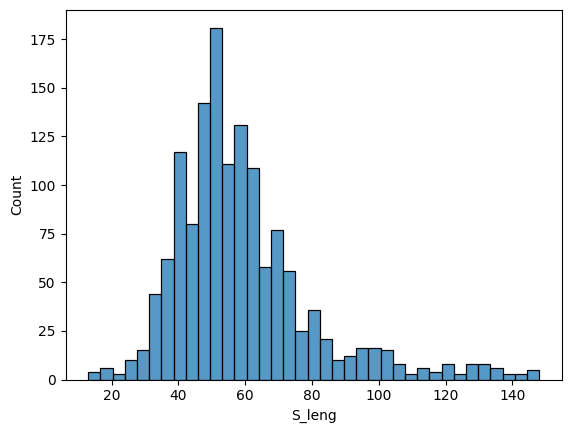

In [15]:
sns.histplot(df['S_leng'])

<Axes: xlabel='IC50', ylabel='Count'>

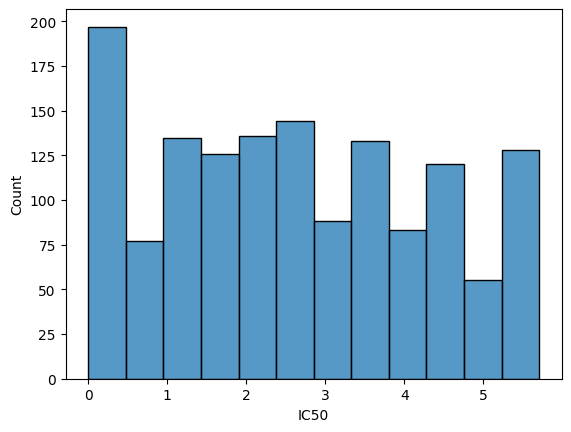

In [16]:
sns.histplot(df['IC50'])

<Axes: xlabel='CC50', ylabel='Count'>

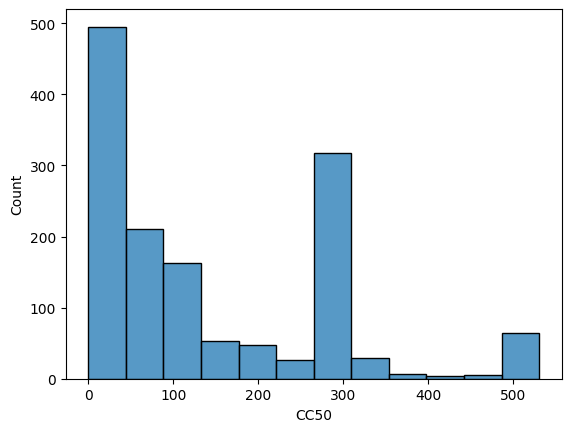

In [17]:
sns.histplot(df['CC50'])

## Векторайзер

In [18]:
PandasTools.AddMoleculeColumnToFrame(df_w,'SMILES','Molecule')
df_w[["SMILES", "Molecule"]]

/usr/local/lib/python3.10/dist-packages/rdkit/Chem/PandasTools.py:371: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame[molCol] = frame[smilesCol].map(Chem.MolFromSmiles)


,SMILES,Molecule
0,OCC\N=C(\[C@]12C)C[C@@H](C1(C)C)CC2,<rdkit.Chem.rdchem.Mol object at 0x7cac67bd42e0>
1,OCC\N=C(\[C@]12C)C[C@@H](C1(C)C)CC2,<rdkit.Chem.rdchem.Mol object at 0x7cac67bd44a0>
2,CCN(CC)CC\N=C(\[C@@]12C)C[C@H](C1(C)C)CC2,<rdkit.Chem.rdchem.Mol object at 0x7cac67bd4430>
3,CN(C)CC\N=C(\[C@@]12C)C[C@H](C1(C)C)CC2,<rdkit.Chem.rdchem.Mol object at 0x7cac67bd45f0>
4,CN(C)CC(=O)O[C@H]1C[C@H](CC2)C(C)(C)[C@@]12C,<rdkit.Chem.rdchem.Mol object at 0x7cac67bd4660>
...,...,...
1459,COC(=O)CN1CCOCC1,<rdkit.Chem.rdchem.Mol object at 0x7cac67a83530>
1460,CC(C)CCCc1c(OC)c(C)c(=O)oc1,<rdkit.Chem.rdchem.Mol object at 0x7cac67a835a0>
1461,C[C@]12C(C)(C)[C@@H](CC2)C[C@H]1O,<rdkit.Chem.rdchem.Mol object at 0x7cac67a83610>
1462,CCCCCCCc1c(O)c(C)c(=O)oc1,<rdkit.Chem.rdchem.Mol object at 0x7cac67a83680>


In [19]:
!python -m pip install git+https://github.com/EBjerrum/molvecgen &> /dev/null

In [20]:
from molvecgen.vectorizers import SmilesVectorizer

In [21]:
smivec = SmilesVectorizer(pad=1, leftpad=True, canonical=False, augment=True)
smivec.fit(df_w.Molecule.values, )

In [22]:
print(smivec.charset)
smivec.dims

F\/rCP+S#@]c.1NeB3[l2noi=IOaH6)(-5s74^$?


(146, 40)

In [23]:
print("Maximum allowed SMILES length %s"%smivec.maxlength)

Maximum allowed SMILES length 145


In [24]:
df_w['IC50']

0       1.308333
1       0.530628
2       2.388763
3       2.230014
4       3.698830
          ...   
1459    5.707110
1460    2.653242
1461    3.218876
1462    2.873565
1463    2.116256
Name: IC50, Length: 1422, dtype: float64

In [25]:
y = df_w['IC50'].values.reshape((-1,1))
X = df_w.drop(['IC50', 'SMILES'], axis=1)
X['Molecule'] = X.Molecule.values
X_train, X_test, y_train, y_test = train_test_split(X, y,  test_size=0.25, random_state=seed)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2, random_state=seed)
#Normalizing output using standard scaling
# scaler = MinMaxScaler()
scaler = StandardScaler()
y_train = scaler.fit_transform(y_train)
y_test = scaler.transform(y_test)
y_validation = scaler.transform(y_validation)

In [26]:
X.head()

,CC50,MW,HBA,HBD,PSA,Molecule
0,500.0,195.307,2,1,32.59,<rdkit.Chem.rdchem.Mol object at 0x7cac67bd42e0>
1,447.0,195.307,2,1,32.59,<rdkit.Chem.rdchem.Mol object at 0x7cac67bd44a0>
2,144.0,250.431,1,0,15.60,<rdkit.Chem.rdchem.Mol object at 0x7cac67bd4430>
3,500.0,222.377,1,0,15.60,<rdkit.Chem.rdchem.Mol object at 0x7cac67bd45f0>
4,143.0,239.361,2,0,29.54,<rdkit.Chem.rdchem.Mol object at 0x7cac67bd4660>


In [27]:
y_train.shape

(852, 1)

In [28]:
y_test.shape

(356, 1)

In [29]:
class SMILESMolDataset(Dataset):
    def __init__(self, x, y, vectorizer):
        x = x.reset_index()
        self.molecules = x['Molecule']
        self.features = x.drop(['Molecule', 'index'], axis=1)
        self.y = y
        self.vectorizer = vectorizer

    def __len__(self):
        return len(self.molecules)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        mols = self.molecules[idx]

        #The vectorizer was written to work with batches,
        #but PyTorch datasets unfortunately works with single samples
        sample = self.vectorizer.transform([mols])[0]
        features = self.features.loc[idx].values
        label = self.y[idx]
        return sample, features, label

In [30]:
train_dataset = SMILESMolDataset(X_train, y_train, smivec)
test_dataset = SMILESMolDataset(X_test, y_test, smivec)
validation_dataset = SMILESMolDataset(X_validation, y_validation, smivec)
train_dataset[0]

(array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 1, 0]], dtype=int8),
 array([143.7  , 574.661,   4.   ,   2.   , 194.78 ]),
 array([0.73048191]))

In [31]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [32]:
class Net(nn.Module):
    def __init__(self, dimensions, hidden_size, dropout_rate, out_size, num_numerical_features):
        super(Net, self).__init__()

        length = dimensions[0]
        number_tokens = dimensions[1]

        self.lstm = nn.GRU(input_size=number_tokens, hidden_size=hidden_size, num_layers=1, batch_first=True, bidirectional=False, dropout = 0.2)
        self.dense = nn.Linear(num_numerical_features, hidden_size)

        self.fc1 = nn.Linear(2*hidden_size, hidden_size)
        self.activation1 = nn.ReLU()

        self.fc2 = nn.Linear(hidden_size, hidden_size//2)
        self.activation2 = nn.ReLU()

        self.fc_out = nn.Linear(hidden_size//2, out_size) # Output layer

        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, molecules_data, numerical_data):# Forward pass: stacking each layer together
        #out, (h_n, c_n) = self.lstm(x) #LSTM network reads in one-hot-encoded SMILES, h_n is last output, out is for all timesteps
        out, h_n = self.lstm(molecules_data) #GRU network reads in one-hot-encoded SMILES, h_n is last output, out is for all timesteps
        molecules_out = self.dropout(h_n) #Dropout
        numerical_out = self.dense(numerical_data)

        combined = torch.cat([molecules_out[0], numerical_out], dim=1)

        out = self.fc1(combined) # Pass into the fc1 layer
        out = self.activation1(out) # Use ReLU on hidden activation

        out = self.fc2(out) # Pass into the fc2 layer
        out = self.activation2(out) # Use ReLU on hidden activation

        out = self.dropout(out) # dropout
        out = self.fc_out(out) # Use a linear layer for the output
        return out

In [33]:
epochs = 100
dims = smivec.dims
hidden_size = 32  # The size of the hidden non-linear layer
dropout_rate = 0.5 # The dropout rate
output_size = 1        # This is just a single task, so this will be one
batch_size = 64   # The mini_batch size during training
learning_rate = 0.003  # The initial learning rate for the optimizer
num_numerical_features = len(train_dataset[0][1])

In [34]:
model = Net(dims, hidden_size, dropout_rate, output_size, num_numerical_features)
model.cuda()

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Net(
  (lstm): GRU(40, 32, batch_first=True, dropout=0.2)
  (dense): Linear(in_features=5, out_features=32, bias=True)
  (fc1): Linear(in_features=64, out_features=32, bias=True)
  (activation1): ReLU()
  (fc2): Linear(in_features=32, out_features=16, bias=True)
  (activation2): ReLU()
  (fc_out): Linear(in_features=16, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [35]:
# criterion = nn.L1Loss()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
lr_scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=50,
                  verbose=True, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=1e-6, eps=1e-08)


In [36]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=batch_size,
                                          shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=True, num_workers=2)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset,
                                          batch_size=batch_size,
                                          shuffle=True, num_workers=2)

In [37]:
model.train() #Ensure the network is in "train" mode with dropouts active
train_losses = []
validation_losses = []
for e in range(epochs):
    running_loss = 0
    for smiles, features, labels in train_loader:
        # Push numpy to CUDA tensors
        smiles = smiles.clone().detach().to(device).float()
        features = features.clone().detach().to(device).float()
        labels = labels.clone().detach().to(device).float()
        labels = torch.nan_to_num(labels, nan = torch.nanmean(labels))
        #print(labels)
        #break
        # Training pass
        optimizer.zero_grad() # Initialize the gradients, which will be recorded during the forward pass

        output = model(smiles, features) #Forward pass of the mini-batch
        loss = criterion(output, labels) #Computing the loss

        loss.backward() # calculate the backward pass
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimizer.step() # Optimize the weights

        running_loss += loss.item()
    else:
        model.eval()
        validation_loss = 0
        for smiles, features, labels in validation_loader:
            smiles = smiles.clone().detach().to(device).float()
            features = features.clone().detach().to(device).float()
            labels = labels.clone().detach().to(device).float()
            labels = torch.nan_to_num(labels, nan = torch.nanmean(labels))

            output = model(smiles, features) #Forward pass of the mini-batch
            loss = criterion(output, labels) #Computing the loss
            validation_loss += loss.item()

        validation_loss /= len(validation_loader)
        lr_scheduler.step(validation_loss)

        model.train()

        train_loss = running_loss/len(train_loader)
        train_losses.append(train_loss)
        validation_losses.append(validation_loss)
        if (e+1)%5 == 0:
            print("Epoch %i, Training loss: %0.5F Validation loss: %0.5F"%(e + 1, train_loss, validation_loss))

Epoch 5, Training loss: 0.95384 Validation loss: 0.95652
Epoch 10, Training loss: 0.95723 Validation loss: 0.92274
Epoch 15, Training loss: 0.92157 Validation loss: 0.99652
Epoch 20, Training loss: 0.87581 Validation loss: 0.98611
Epoch 25, Training loss: 0.92934 Validation loss: 0.90901
Epoch 30, Training loss: 0.87066 Validation loss: 0.79109
Epoch 35, Training loss: 0.85683 Validation loss: 0.71459
Epoch 40, Training loss: 0.81585 Validation loss: 0.72984
Epoch 45, Training loss: 0.80685 Validation loss: 0.82520
Epoch 50, Training loss: 0.75280 Validation loss: 0.73239
Epoch 55, Training loss: 0.80015 Validation loss: 0.71739
Epoch 60, Training loss: 0.77089 Validation loss: 0.80627
Epoch 65, Training loss: 0.84290 Validation loss: 0.90053
Epoch 70, Training loss: 0.79031 Validation loss: 0.78052
Epoch 75, Training loss: 0.76241 Validation loss: 0.78172
Epoch 80, Training loss: 0.74982 Validation loss: 0.72702
Epoch 85, Training loss: 0.79328 Validation loss: 0.68607
Epoch 90, Train

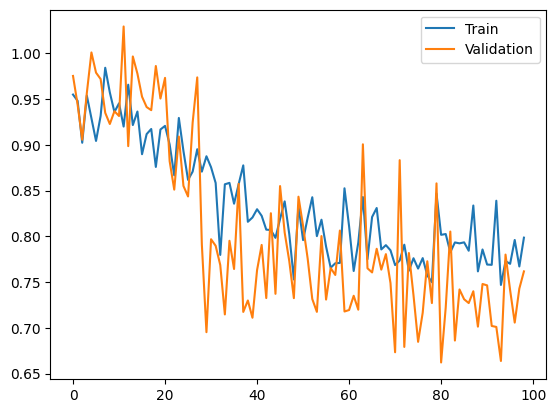

In [44]:
plt.plot(train_losses[1:], label="Train")
plt.plot(validation_losses[1:], label="Validation")
#plt.yscale('log')
plt.legend()

In [39]:
model.eval();

In [40]:
torch.cuda.empty_cache()

In [41]:
vert = np.array(y_test.tolist()).flatten()
horz = list()
for i in range(len(test_dataset)):
    smiles, features, label = test_dataset[0]
    smiles = torch.tensor([smiles]).clone().detach().to(device).float()
    features = torch.tensor([features]).clone().detach().to(device).float()
    horz.append(model.forward(smiles, features).item())
horz = np.array(horz)

<ipython-input-41-9062bd0a89a3>:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  smiles = torch.tensor([smiles]).clone().detach().to(device).float()


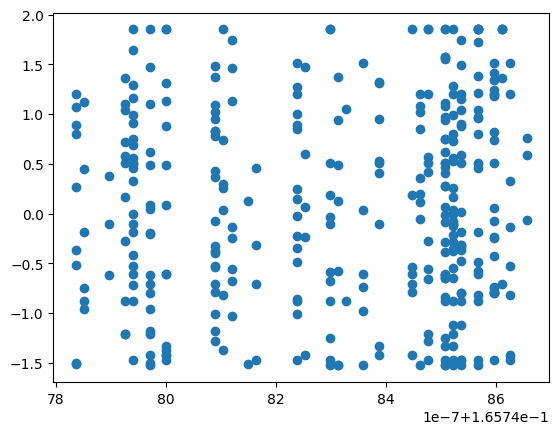

In [42]:
plt.scatter(horz, vert)